In [7]:
# Cell 4 — imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import seaborn as sns
from datetime import datetime, timedelta
from scipy.stats import mannwhitneyu, ttest_ind, chi2_contingency
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix
print("Imports done")
pd.set_option('display.max_columns', 200)

Imports done


In [8]:
# Cell 5 — load the csvs (try common encodings)
def smart_read_csv(path, parse_dates=None):
    for enc in ['utf-8','latin1','ISO-8859-1']:
        try:
            return pd.read_csv(path, parse_dates=parse_dates, encoding=enc)
        except Exception as e:
            last_e = e
    raise last_e

traders = smart_read_csv(hyperliquid_path, parse_dates=['time'] if 'time' in open(hyperliquid_path).read() else None)
sentiment = smart_read_csv(feargreed_path)
print("Raw traders rows:", len(traders))
print("Raw sentiment rows:", len(sentiment))
traders.head(2), sentiment.head(2)

Raw traders rows: 211224
Raw sentiment rows: 2644


(                                      Account  Coin  Execution Price  \
 0  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9769   
 1  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9800   
 
    Size Tokens  Size USD Side     Timestamp IST  Start Position Direction  \
 0       986.87   7872.16  BUY  02-12-2024 22:50        0.000000       Buy   
 1        16.00    127.68  BUY  02-12-2024 22:50      986.524596       Buy   
 
    Closed PnL                                   Transaction Hash     Order ID  \
 0         0.0  0xec09451986a1874e3a980418412fcd0201f500c95bac...  52017706630   
 1         0.0  0xec09451986a1874e3a980418412fcd0201f500c95bac...  52017706630   
 
    Crossed       Fee      Trade ID     Timestamp  
 0     True  0.345404  8.950000e+14  1.730000e+12  
 1     True  0.005600  4.430000e+14  1.730000e+12  ,
     timestamp  value classification        date
 0  1517463000     30           Fear  2018-02-01
 1  1517549400     15   Extreme Fear  20

In [9]:
# Cell 6 — quick inspection & standardize column names
def clean_colnames(df):
    df = df.copy()
    df.columns = [c.strip().lower().replace(' ', '_').replace('-', '_') for c in df.columns]
    return df

traders = clean_colnames(traders)
sentiment = clean_colnames(sentiment)

print("Trader cols:", traders.columns.tolist()[:30])
print("Sentiment cols:", sentiment.columns.tolist())

Trader cols: ['account', 'coin', 'execution_price', 'size_tokens', 'size_usd', 'side', 'timestamp_ist', 'start_position', 'direction', 'closed_pnl', 'transaction_hash', 'order_id', 'crossed', 'fee', 'trade_id', 'timestamp']
Sentiment cols: ['timestamp', 'value', 'classification', 'date']


In [10]:
# Cell 7 — parse times, create date column
# Traders may have a column named 'time' or similar. Ensure it's datetime.
time_cols = [c for c in traders.columns if 'time' in c or 'timestamp' in c]
print("Detected time cols in traders:", time_cols)

if len(time_cols)==0:
    # user may need to inspect and modify
    print("No time column detected automatically. Please ensure raw data has a time column.")
else:
    tcol = time_cols[0]
    traders[tcol] = pd.to_datetime(traders[tcol], errors='coerce', utc=True)
    traders['date'] = traders[tcol].dt.date

# For sentiment ensure Date is parsed
date_cols = [c for c in sentiment.columns if 'date' in c]
if len(date_cols)==0:
    # Might have 'timestamp' or similar — try to find first column that looks like date
    possible = sentiment.columns[0]
    sentiment[possible] = pd.to_datetime(sentiment[possible], errors='coerce')
    sentiment.rename(columns={possible:'date'}, inplace=True)
else:
    sentiment[date_cols[0]] = pd.to_datetime(sentiment[date_cols[0]], errors='coerce')
    sentiment.rename(columns={date_cols[0]:'date'}, inplace=True)

sentiment['date'] = sentiment['date'].dt.date
traders['date'] = pd.to_datetime(traders['date'])
sentiment['date'] = pd.to_datetime(sentiment['date'])

print("Sample trader times:", traders[tcol].head(2))
print("Sample sentiment dates:", sentiment['date'].head(2))

Detected time cols in traders: ['timestamp_ist', 'timestamp']
Sample trader times: 0   2024-02-12 22:50:00+00:00
1   2024-02-12 22:50:00+00:00
Name: timestamp_ist, dtype: datetime64[ns, UTC]
Sample sentiment dates: 0   2018-02-01
1   2018-02-02
Name: date, dtype: datetime64[ns]


In [14]:
# Replace the failing "Cell 8" with this robust cleaning cell

import pytz
import numpy as np

print("Starting robust cleaning (replacement for Cell 8)...")

# 1) Choose timestamp column
if 'timestamp_ist' in traders.columns:
    tcol = 'timestamp_ist'
elif 'timestamp' in traders.columns:
    tcol = 'timestamp'
else:
    cand = [c for c in traders.columns if 'time' in c or 'timestamp' in c]
    tcol = cand[0] if cand else None

if tcol is None:
    raise RuntimeError("No timestamp-like column found. Columns: " + str(traders.columns.tolist()))
print("Using timestamp column:", tcol)

# 2) Parse timestamps and create 'date' (convert IST -> UTC when needed)
if tcol == 'timestamp_ist':
    traders[tcol] = pd.to_datetime(traders[tcol], errors='coerce', dayfirst=False)
    if traders[tcol].dt.tz is None:
        traders[tcol] = traders[tcol].dt.tz_localize('Asia/Kolkata', ambiguous='NaT', nonexistent='NaT').dt.tz_convert('UTC')
else:
    traders[tcol] = pd.to_datetime(traders[tcol], errors='coerce', utc=True)

# create date column (UTC midnight)
traders['date'] = traders[tcol].dt.tz_convert('UTC').dt.date
traders['date'] = pd.to_datetime(traders['date'])

# 3) Create unified 'size' column (prefer USD)
if 'size_usd' in traders.columns and traders['size_usd'].notna().any():
    traders['size'] = pd.to_numeric(traders['size_usd'], errors='coerce')
    used_size = 'size_usd'
elif 'size_tokens' in traders.columns and traders['size_tokens'].notna().any():
    traders['size'] = pd.to_numeric(traders['size_tokens'], errors='coerce')
    used_size = 'size_tokens'
elif 'size' in traders.columns:
    traders['size'] = pd.to_numeric(traders['size'], errors='coerce')
    used_size = 'size (existing)'
else:
    raise RuntimeError("No usable size column found. Available: " + ", ".join(traders.columns.tolist()))
print("Unified 'size' created from:", used_size)

# 4) Numeric conversions for other important cols
for c in ['execution_price', 'closed_pnl', 'closedpnl', 'fee', 'leverage']:
    if c in traders.columns:
        traders[c] = pd.to_numeric(traders[c], errors='coerce')

# map closed_pnl to 'pnl' for consistency
if 'closed_pnl' in traders.columns:
    traders['pnl'] = traders['closed_pnl']
elif 'closedpnl' in traders.columns:
    traders['pnl'] = traders['closedpnl']
else:
    traders['pnl'] = pd.to_numeric(traders.get('pnl'), errors='coerce')

# 5) Normalize side/direction
if 'side' in traders.columns:
    traders['side'] = traders['side'].astype(str).str.lower().str.strip()
elif 'direction' in traders.columns:
    traders['side'] = traders['direction'].astype(str).str.lower().str.strip()
else:
    traders['side'] = np.nan

# 6) Drop rows missing required fields — only require columns that actually exist
required = ['date', 'size', 'execution_price', 'side']
required_existing = [c for c in required if c in traders.columns]
before = len(traders)
traders = traders.dropna(subset=required_existing, how='any')
after = len(traders)
print(f"Dropped {before-after} rows missing required fields: {required_existing}. Remaining rows: {after}")

# 7) Sanity filters: positive execution price and non-zero absolute size
traders = traders[(traders['execution_price'] > 0) & (traders['size'].abs() > 0)]
print("After positive price & non-zero size filter:", len(traders))

# 8) Derived columns used later
traders['abs_size'] = traders['size'].abs()
traders['is_win'] = traders['pnl'] > 0

# 9) Show a quick sample for verification
show_cols = ['date','account','coin','execution_price','size','abs_size','pnl','side','leverage','fee','timestamp_ist','timestamp']
existing_show = [c for c in show_cols if c in traders.columns]
print("Displaying first 5 rows of key cols:", existing_show)
display(traders[existing_show].head().T)

print("Cleaning complete — re-run your aggregation cells next.")

Starting robust cleaning (replacement for Cell 8)...
Using timestamp column: timestamp_ist
Unified 'size' created from: size_usd
Dropped 131999 rows missing required fields: ['date', 'size', 'execution_price', 'side']. Remaining rows: 79225
After positive price & non-zero size filter: 79212
Displaying first 5 rows of key cols: ['date', 'account', 'coin', 'execution_price', 'size', 'abs_size', 'pnl', 'side', 'fee', 'timestamp_ist', 'timestamp']


,0,1,2,3,4
date,2024-02-12 00:00:00,2024-02-12 00:00:00,2024-02-12 00:00:00,2024-02-12 00:00:00,2024-02-12 00:00:00
account,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,0xae5eacaf9c6b9111fd53034a602c192a04e082ed
coin,@107,@107,@107,@107,@107
execution_price,7.9769,7.98,7.9855,7.9874,7.9894
size,7872.16,127.68,1150.63,1142.04,69.75
abs_size,7872.16,127.68,1150.63,1142.04,69.75
pnl,0.0,0.0,0.0,0.0,0.0
side,buy,buy,buy,buy,buy
fee,0.345404,0.0056,0.050431,0.050043,0.003055
timestamp_ist,2024-02-12 22:50:00+00:00,2024-02-12 22:50:00+00:00,2024-02-12 22:50:00+00:00,2024-02-12 22:50:00+00:00,2024-02-12 22:50:00+00:00


Cleaning complete — re-run your aggregation cells next.


In [15]:
# Cell 9 — flag & cap crazy values
if 'leverage' in traders.columns:
    traders['leverage'] = pd.to_numeric(traders['leverage'], errors='coerce')
    # cap leverage to 200 (adjust if necessary)
    traders.loc[traders['leverage']>200, 'leverage'] = np.nan

# size and execution price sanity
traders = traders[(traders['size'].abs() > 0) & (traders['execution_price'] > 0)]
print("After sanity filters:", len(traders))

After sanity filters: 79212


In [16]:
# Cell 10 — engineer per-trade derived cols
traders['abs_size'] = traders['size'].abs()
# some datasets use closedPnL or closedpnl
pnl_col = 'closedpnl' if 'closedpnl' in traders.columns else ('closed_pnl' if 'closed_pnl' in traders.columns else None)
if pnl_col:
    traders['pnl'] = pd.to_numeric(traders[pnl_col], errors='coerce')
else:
    traders['pnl'] = np.nan

# mark winners
traders['is_win'] = traders['pnl'] > 0

In [18]:
# Cell 11 — corrected daily aggregations

# If leverage column does NOT exist, create it as NaN so pipeline does not break
if 'leverage' not in traders.columns:
    traders['leverage'] = np.nan
    print("Note: 'leverage' column not found — filled with NaN for all rows.")

daily = traders.groupby('date').agg(
    daily_volume = ('abs_size', 'sum'),
    daily_trades = ('size', 'count'),
    daily_net_pnl = ('pnl', 'sum'),
    daily_avg_leverage = ('leverage', 'mean'),   # will be NaN if leverage missing
    daily_winrate = ('is_win', 'mean'),
    daily_avg_position = ('abs_size', 'mean'),
).reset_index()

daily['date'] = pd.to_datetime(daily['date'])
daily = daily.sort_values('date')

daily.head(3)

Note: 'leverage' column not found — filled with NaN for all rows.


,date,daily_volume,daily_trades,daily_net_pnl,daily_avg_leverage,daily_winrate,daily_avg_position
0,2023-01-05,477.00,3,0.00000,NaN,0.000000,159.000000
1,2023-05-12,50005.83,9,0.00000,NaN,0.000000,5556.203333
2,2024-01-01,264239.53,18,-129.53146,NaN,0.055556,14679.973889


In [19]:
# Cell 12 — Map sentiment classification to a numeric score & merge
# Many fear/greed datasets use values like 'Fear'/'Greed' or a numeric index. Inspect sentiment.
print("Sentiment columns:", sentiment.columns.tolist())
print(sentiment.head(5))

# Attempt to find classification column
class_col_candidates = [c for c in sentiment.columns if 'class' in c or 'classification' in c or 'fear' in c or 'greed' in c]
print("Sentiment classification candidates:", class_col_candidates)
if len(class_col_candidates)>0:
    class_col = class_col_candidates[0]
else:
    # try second column
    class_col = sentiment.columns[1] if len(sentiment.columns)>1 else sentiment.columns[0]

# Normalize values
sentiment['classification'] = sentiment[class_col].astype(str).str.strip().str.title()
# Map to numeric: Greed=1, Fear=0. If a numeric column exists, use that too.
if 'value' in sentiment.columns:
    sentiment['sentiment_value'] = pd.to_numeric(sentiment['value'], errors='coerce')
else:
    # fallback: map classification to 0/1
    sentiment['sentiment_value'] = sentiment['classification'].map({'Fear':0,'Greed':1})
sentiment = sentiment[['date','classification','sentiment_value']].drop_duplicates(subset=['date'])
sentiment['date'] = pd.to_datetime(sentiment['date'])
print("Sentiment sample after normalization:", sentiment.head(5))

# Merge
merged = pd.merge(daily, sentiment, on='date', how='left')
print("Merged rows:", len(merged), "with sentiment nulls:", merged['classification'].isna().sum())
merged.head(3)

Sentiment columns: ['timestamp', 'value', 'classification', 'date']
    timestamp  value classification       date
0  1517463000     30           Fear 2018-02-01
1  1517549400     15   Extreme Fear 2018-02-02
2  1517635800     40           Fear 2018-02-03
3  1517722200     24   Extreme Fear 2018-02-04
4  1517808600     11   Extreme Fear 2018-02-05
Sentiment classification candidates: ['classification']
Sentiment sample after normalization:         date classification  sentiment_value
0 2018-02-01           Fear               30
1 2018-02-02   Extreme Fear               15
2 2018-02-03           Fear               40
3 2018-02-04   Extreme Fear               24
4 2018-02-05   Extreme Fear               11
Merged rows: 188 with sentiment nulls: 30


,date,daily_volume,daily_trades,daily_net_pnl,daily_avg_leverage,daily_winrate,daily_avg_position,classification,sentiment_value
0,2023-01-05,477.00,3,0.00000,NaN,0.000000,159.000000,Fear,29.0
1,2023-05-12,50005.83,9,0.00000,NaN,0.000000,5556.203333,Neutral,49.0
2,2024-01-01,264239.53,18,-129.53146,NaN,0.055556,14679.973889,Greed,65.0


In [20]:
# Cell 13 — Save cleaned CSVs expected by the assignment
traders.to_csv(os.path.join(CSV_DIR, "traders_clean.csv"), index=False)
sentiment.to_csv(os.path.join(CSV_DIR, "sentiment_clean.csv"), index=False)
daily.to_csv(os.path.join(CSV_DIR, "daily_trader_agg.csv"), index=False)
merged.to_csv(os.path.join(CSV_DIR, "merged_sentiment_trader.csv"), index=False)
print("Saved cleaned CSVs to", CSV_DIR)

Saved cleaned CSVs to csv_files


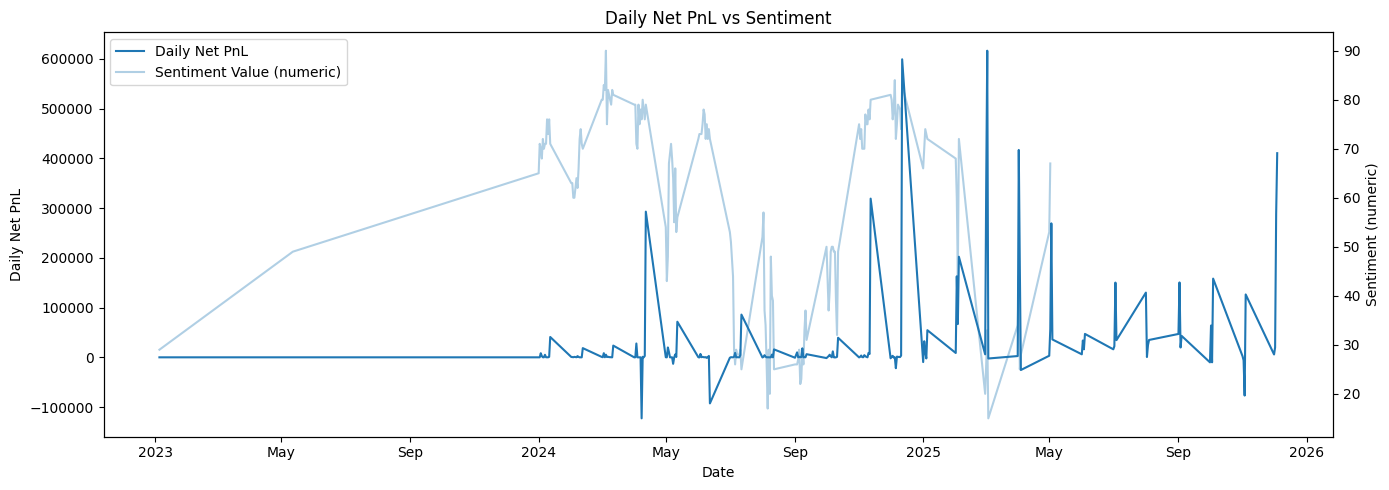

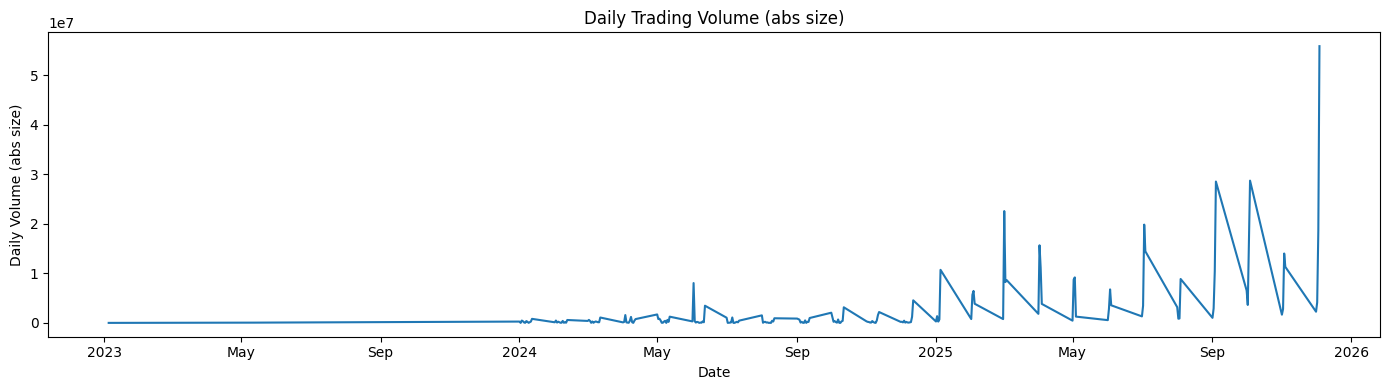

No leverage data available (daily_avg_leverage all NaN). Skipping leverage plots and leverage-related stats.
Skipping leverage summary: not enough leverage data by classification.
Mann-Whitney U test on daily_net_pnl (Fear vs Greed): U=1126.500, p=0.47880
Fear pnl median/mean/count: 1147.595856 48087.17790956756 37
Greed pnl median/mean/count: 423.0833185 10886.295225642856 56
Contingency table (classification x profitable_day):
 profitable_day  False  True 
classification              
Extreme Fear        3      3
Extreme Greed      12     31
Fear               11     26
Greed              16     40
Neutral             7      9
Chi-square not run: contingency table shape not 2x2. Found shape: (5, 2)
Saved EDA figures (where applicable) to outputs


In [22]:
# Replacement for Cell 14 + Cell 15: robust plotting + stats handling when 'leverage' may be missing

import matplotlib.dates as mdates

# Ensure merged has proper date dtype and is sorted
merged['date'] = pd.to_datetime(merged['date'])
merged = merged.sort_values('date').reset_index(drop=True)

# --------- 1) Time-series: Daily Net PnL vs Sentiment (if available) ----------
plt.figure(figsize=(14,5))
ax = plt.gca()
ax.plot(merged['date'], merged['daily_net_pnl'], label='Daily Net PnL')
ax.set_xlabel('Date')
ax.set_ylabel('Daily Net PnL')

# secondary axis for sentiment value if present
if 'sentiment_value' in merged.columns and merged['sentiment_value'].notna().any():
    ax2 = ax.twinx()
    ax2.plot(merged['date'], merged['sentiment_value'], alpha=0.35, label='Sentiment Value (numeric)')
    ax2.set_ylabel('Sentiment (numeric)')
    # legends
    lines, labels = ax.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax.legend(lines + lines2, labels + labels2, loc='upper left')
else:
    ax.legend(loc='upper left')

# better x-axis ticks
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))

plt.title('Daily Net PnL vs Sentiment')
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "pnl_vs_sentiment.png"), bbox_inches='tight', dpi=150)
plt.show()

# --------- 2) Volume time series ----------
plt.figure(figsize=(14,4))
plt.plot(merged['date'], merged['daily_volume'])
plt.title('Daily Trading Volume (abs size)')
plt.xlabel('Date')
plt.ylabel('Daily Volume (abs size)')
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.gca().xaxis.set_major_formatter(mdates.ConciseDateFormatter(plt.gca().xaxis.get_major_locator()))
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "volume_vs_sentiment.png"), bbox_inches='tight', dpi=150)
plt.show()

# --------- 3) Leverage analyses: skip gracefully if leverage unavailable ----------
if merged['daily_avg_leverage'].notna().any():
    # boxplot of per-trade leverage grouped by classification (work off traders merged with sentiment)
    if 'leverage' in traders.columns and 'classification' in sentiment.columns:
        tmp = traders.merge(sentiment[['date','classification']], on='date', how='left')
        if tmp['leverage'].notna().any():
            plt.figure(figsize=(8,5))
            sns.boxplot(data=tmp, x='classification', y='leverage')
            plt.title('Per-trade Leverage by Sentiment Classification')
            plt.tight_layout()
            plt.savefig(os.path.join(OUT_DIR, "leverage_by_sentiment.png"), bbox_inches='tight', dpi=150)
            plt.show()
        else:
            print("Per-trade 'leverage' exists but is all NaN — skipping leverage boxplot.")
    else:
        print("Per-trade 'leverage' or sentiment classification missing — skipping per-trade leverage boxplot.")

    # scatter: daily_avg_leverage vs daily_net_pnl
    plt.figure(figsize=(8,5))
    plt.scatter(merged['daily_avg_leverage'], merged['daily_net_pnl'], alpha=0.7)
    plt.xlabel('Daily Avg Leverage')
    plt.ylabel('Daily Net PnL')
    plt.title('Daily Avg Leverage vs Daily Net PnL')
    plt.tight_layout()
    plt.savefig(os.path.join(OUT_DIR, "leverage_vs_pnl_scatter.png"), bbox_inches='tight', dpi=150)
    plt.show()
else:
    print("No leverage data available (daily_avg_leverage all NaN). Skipping leverage plots and leverage-related stats.")

# --------- 4) Distribution comparisons & quick stats (Leverage summary if available) ----------
if merged.dropna(subset=['classification','daily_avg_leverage']).shape[0] > 0:
    mg = merged.dropna(subset=['classification','daily_avg_leverage'])
    grouped = mg.groupby('classification')['daily_avg_leverage'].agg(['median','mean','count']).reset_index()
    print("Leverage summary by sentiment:\n", grouped)
else:
    print("Skipping leverage summary: not enough leverage data by classification.")

# --------- 5) Mann-Whitney test on daily_net_pnl (Fear vs Greed) ----------
fear_pnl = merged.loc[merged['classification']=='Fear','daily_net_pnl'].dropna()
greed_pnl = merged.loc[merged['classification']=='Greed','daily_net_pnl'].dropna()
if len(fear_pnl) >= 5 and len(greed_pnl) >= 5:
    stat, p = mannwhitneyu(fear_pnl, greed_pnl, alternative='two-sided')
    print(f"Mann-Whitney U test on daily_net_pnl (Fear vs Greed): U={stat:.3f}, p={p:.5f}")
    # Also print simple descriptive stats
    print("Fear pnl median/mean/count:", fear_pnl.median(), fear_pnl.mean(), len(fear_pnl))
    print("Greed pnl median/mean/count:", greed_pnl.median(), greed_pnl.mean(), len(greed_pnl))
else:
    print("Not enough samples in one or both groups to run Mann-Whitney reliably. Counts -> Fear:", len(fear_pnl), "Greed:", len(greed_pnl))

# --------- 6) Proportion test: profitable days fraction in Fear vs Greed ----------
if 'classification' in merged.columns:
    merged['profitable_day'] = merged['daily_net_pnl'] > 0
    ct = pd.crosstab(merged['classification'], merged['profitable_day']).fillna(0).astype(int)
    print("Contingency table (classification x profitable_day):\n", ct)
    # need exactly two classification rows and two columns for chi2
    if ct.shape == (2,2):
        chi2, pval, dof, expected = chi2_contingency(ct.values)
        print(f"Chi-square test: chi2={chi2:.3f}, p={pval:.5f}")
    else:
        print("Chi-square not run: contingency table shape not 2x2. Found shape:", ct.shape)
else:
    print("No 'classification' column in merged — skipping proportion test.")

print("Saved EDA figures (where applicable) to", OUT_DIR)

In [23]:
# Cell 16 — Proportion test: profitable days fraction in Fear vs Greed
merged['profitable_day'] = merged['daily_net_pnl'] > 0
ct = pd.crosstab(merged['classification'], merged['profitable_day']).fillna(0).astype(int)
print("Contingency table:\n", ct)
if ct.shape == (2,2):
    chi2, pval, dof, expected = chi2_contingency(ct.values)
    print("Chi-sq test: chi2=", chi2, "p=", pval)
else:
    print("Chi-sq test not run: need two classification groups and binary outcome")

Contingency table:
 profitable_day  False  True 
classification              
Extreme Fear        3      3
Extreme Greed      12     31
Fear               11     26
Greed              16     40
Neutral             7      9
Chi-sq test not run: need two classification groups and binary outcome


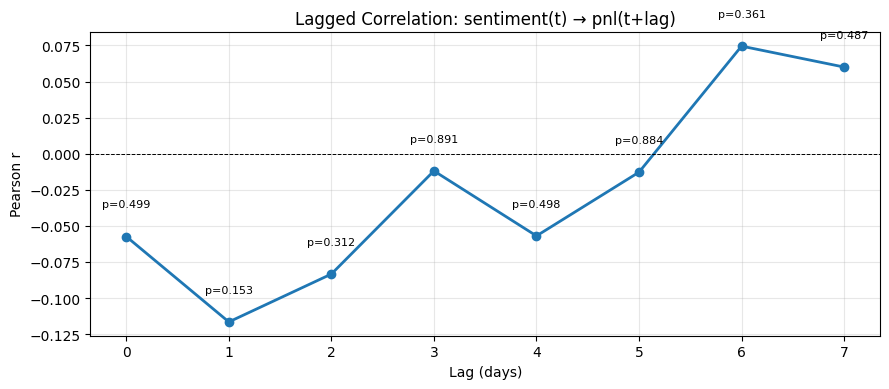

,lag,r,n_pairs,p_perm
0,0,-0.057252,158,0.498501
1,1,-0.116326,158,0.152847
2,2,-0.083182,158,0.311688
3,3,-0.011835,158,0.891109
4,4,-0.056807,158,0.497502
5,5,-0.012696,158,0.884116
6,6,0.074499,158,0.360639
7,7,0.060020,158,0.486513


In [25]:
# Robust Lag Correlation + Permutation P-values (compatible with older matplotlib)

import numpy as np
import matplotlib.pyplot as plt

def lag_corr_with_pvals(series_x, series_y, maxlag=7, n_perm=1000, min_pairs=10, random_state=42):
    np.random.seed(random_state)

    df = pd.DataFrame({'x': series_x, 'y': series_y}).sort_index()
    results = {'lag': [], 'r': [], 'n_pairs': [], 'p_perm': []}

    for lag in range(maxlag + 1):
        y_shift = df['y'].shift(-lag)
        valid = df['x'].notna() & y_shift.notna()
        n = valid.sum()

        if n >= min_pairs:
            x_vals = df.loc[valid, 'x'].values
            y_vals = y_shift[valid].values

            # Pearson correlation
            r = np.corrcoef(x_vals, y_vals)[0, 1]

            # Permutation test
            perm_rs = []
            for _ in range(n_perm):
                perm_r = np.corrcoef(x_vals, np.random.permutation(y_vals))[0, 1]
                perm_rs.append(perm_r)

            perm_rs = np.array(perm_rs)
            p_perm = (np.sum(np.abs(perm_rs) >= np.abs(r)) + 1) / (n_perm + 1)

        else:
            r, p_perm = np.nan, np.nan
            n = int(n)

        results['lag'].append(lag)
        results['r'].append(r)
        results['n_pairs'].append(n)
        results['p_perm'].append(p_perm)

    return pd.DataFrame(results)


# Run lag correlation
sent_series = merged.set_index('date')['sentiment_value']
pnl_series  = merged.set_index('date')['daily_net_pnl']

lag_df = lag_corr_with_pvals(sent_series, pnl_series, maxlag=7, n_perm=1000, min_pairs=8)

# Plot
plt.figure(figsize=(9,4))
plt.plot(lag_df['lag'], lag_df['r'], marker='o', linewidth=2)
plt.axhline(0, color='black', linewidth=0.7, linestyle='--')

# Annotate p-values
for i, row in lag_df.iterrows():
    if not np.isnan(row['p_perm']):
        plt.text(row['lag'], row['r'] + 0.02, f"p={row['p_perm']:.3f}", 
                 ha='center', fontsize=8)

plt.title("Lagged Correlation: sentiment(t) → pnl(t+lag)")
plt.xlabel("Lag (days)")
plt.ylabel("Pearson r")
plt.grid(alpha=0.3)
plt.tight_layout()

plt.savefig(os.path.join(OUT_DIR, "lag_corr_sentiment_pnl.png"), dpi=150)
plt.show()

lag_df

In [26]:
lag_df

,lag,r,n_pairs,p_perm
0,0,-0.057252,158,0.498501
1,1,-0.116326,158,0.152847
2,2,-0.083182,158,0.311688
3,3,-0.011835,158,0.891109
4,4,-0.056807,158,0.497502
5,5,-0.012696,158,0.884116
6,6,0.074499,158,0.360639
7,7,0.060020,158,0.486513
